# 1. Вычисления на GPU. Проект: ускорение инференса нейросети

**ФИО**: Хоружев Илья Максимович

Будем по картинке определять одежду с помощью самописной нейросети

In [1]:
import torch

torch.cuda.get_device_name("cuda:0")

'NVIDIA GeForce RTX 4070'

In [2]:
import numpy as np
import torch

from matplotlib import pyplot as plt

from torch import nn
from torch.autograd import Function
from torch.autograd import gradcheck
from torch.optim import Optimizer
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets

In [3]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True
)

In [4]:
import os

def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

class FashionMnist(Dataset):
    def __init__(self, path, train=True, image_transform=None,
                 label_transform=None):
        if train:
            images, labels = load_mnist(os.path.join(path,"raw"))
        else:
            images, labels = load_mnist(os.path.join(path,"raw"), kind="t10k")
        
        if image_transform is not None:
            self._images = image_transform(images.astype(np.float32))
        else:
            self._images = images.astype(np.float32)
        
        if label_transform is not None:  
            self._labels = label_transform(labels)
        else:
            self._labels = labels

    def __len__(self,):
        return len(self._labels)

    def __getitem__(self, idx):
        img = self._images[idx].reshape((28, 28))
        label = self._labels[idx]
        
        return img, label

test_dataset = FashionMnist("data/FashionMNIST", train=False)
train_dataset = FashionMnist("data/FashionMNIST")

Визуализируйте случайные элементы набора данных.

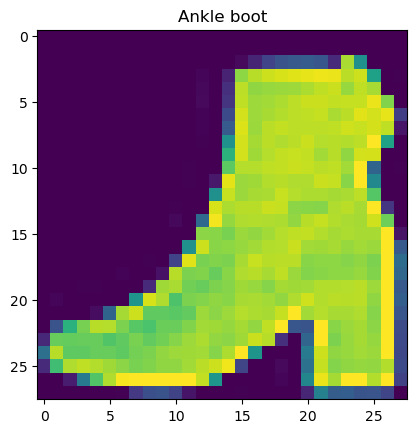

In [5]:
classes = {
    0: "T-shirt/top", 
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

ind = np.random.randint(len(train_dataset))

plt.imshow(train_dataset[ind][0])
plt.title(classes[train_dataset[ind][1]])
plt.show()

In [6]:
class ToTensor:
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        return torch.from_numpy(sample)

transform = ToTensor()

test_dataset = FashionMnist("data/FashionMNIST",
                            train=False,
                            image_transform=transform,
                            label_transform=transform
                            )
train_dataset = FashionMnist("data/FashionMNIST",
                             image_transform=transform,
                             label_transform=transform
                             )

/tmp/ipykernel_4478/2421384196.py:5: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1695627723575/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.from_numpy(sample)


In [7]:
def collate(batch):
    imgs = torch.tensor([(item[0].ravel() / 255).tolist() for item in batch])
    labels = torch.tensor([item[1].tolist() for item in batch])
    
    return imgs, labels

test_dataloader = DataLoader(test_dataset, batch_size=15, num_workers=2,
                             shuffle=True, collate_fn=collate)
train_dataloader = DataLoader(train_dataset, batch_size=15, num_workers=2,
                              shuffle=True, collate_fn=collate)
batch = next(iter(test_dataloader))

print(f"The length of the batch is {len(batch)}")
print(f"The shape of the batch[0] is {batch[0].shape}")

The length of the batch is 2
The shape of the batch[0] is torch.Size([15, 784])


In [8]:
from neural_net import Network, CrossEntropy
from training import perform_epoch

Теперь обучим нашу нейронную сеть c разными размерностями скрытых слоев (32, 128, 512, 1024, 1532)

In [9]:
model32 = Network(num_layers=4, dropout_prob=0, hidden_layers_size=32)
optimizer = torch.optim.Adam(model32.parameters())
criterion = CrossEntropy()

device = 'cpu'

model32.to(device)

for epoch in range(3):
    loss, acc = perform_epoch(model32, train_dataloader, criterion,
                                optimizer=optimizer, device=device)
    print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

100%|██████████| 4000/4000 [00:04<00:00, 824.07it/s]


Epoch - 0 : loss 0.5383268827819265, accuracy 0.8060328960418701
Current learning rate: 0.001


100%|██████████| 4000/4000 [00:04<00:00, 859.89it/s]


Epoch - 1 : loss 0.400562827116577, accuracy 0.8556509613990784
Current learning rate: 0.001


100%|██████████| 4000/4000 [00:04<00:00, 839.03it/s]

Epoch - 2 : loss 0.36788649309135507, accuracy 0.865666389465332
Current learning rate: 0.001


In [10]:
model32.eval()

Network(
  (activations): ModuleDict(
    (relu): ReLU()
  )
  (layers): ModuleList(
    (0): Linear(784, 32)
    (1): ReLU()
    (2): Linear(32, 32)
    (3): ReLU()
    (4): Linear(32, 32)
    (5): ReLU()
    (6): Linear(32, 10)
    (7): LogSoftmax()
  )
)

In [11]:
%%timeit

with torch.no_grad():
    for batch_data, batch_labels in train_dataloader:
        model_labels = model32(batch_data)

3.11 s ± 77.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Загрузим веса в класс для инференса

In [12]:
from inference_cuda import NeuralNetworkCUDA

weights = [x.detach().numpy() for x in model32.parameters() if len(x.shape) == 2]
biases = [x.detach().numpy() for x in model32.parameters() if len(x.shape) == 1]

inference_model = NeuralNetworkCUDA(784, 10, 32)
inference_model.load_model(weights, biases)

In [13]:
%%timeit

for batch_data, batch_labels in train_dataloader:
    model_labels = inference_model.apply(batch_data)

3.37 s ± 31.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


на гпу дольше вычисляется из-за не самойэффективной реализации 

### 128

In [33]:
model128     = Network(num_layers=4, dropout_prob=0, hidden_layers_size=128)
optimizer = torch.optim.Adam(model128.parameters())
criterion = CrossEntropy()

device = 'cpu'

model128.to(device)

for epoch in range(3):
    loss, acc = perform_epoch(model128, train_dataloader, criterion,
                                optimizer=optimizer, device=device)
    print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

100%|██████████| 4000/4000 [00:05<00:00, 711.37it/s]


Epoch - 0 : loss 0.48991525602107866, accuracy 0.8260159492492676
Current learning rate: 0.001


100%|██████████| 4000/4000 [00:05<00:00, 730.89it/s]


Epoch - 1 : loss 0.3765409529886674, accuracy 0.8623170852661133
Current learning rate: 0.001


100%|██████████| 4000/4000 [00:05<00:00, 734.56it/s]

Epoch - 2 : loss 0.34027606404596006, accuracy 0.8747332096099854
Current learning rate: 0.001


In [15]:
model128.eval()

Network(
  (activations): ModuleDict(
    (relu): ReLU()
  )
  (layers): ModuleList(
    (0): Linear(784, 128)
    (1): ReLU()
    (2): Linear(128, 128)
    (3): ReLU()
    (4): Linear(128, 128)
    (5): ReLU()
    (6): Linear(128, 10)
    (7): LogSoftmax()
  )
)

In [16]:
%%timeit

with torch.no_grad():
    for batch_data, batch_labels in train_dataloader:
        model_labels = model128(batch_data.to(device))

3.15 s ± 26.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
weights = [x.detach().numpy() for x in model128.parameters() if len(x.shape) == 2]
biases = [x.detach().numpy() for x in model128.parameters() if len(x.shape) == 1]

inference_model = NeuralNetworkCUDA(784, 10, 128)
inference_model.load_model(weights, biases)

In [21]:
%%timeit

for batch_data, batch_labels in train_dataloader:
    model_labels = inference_model.apply(batch_data)

3.33 s ± 15.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


на гпу все еще дольше

In [22]:
model512     = Network(num_layers=4, dropout_prob=0, hidden_layers_size=512)
optimizer = torch.optim.Adam(model512.parameters())
criterion = CrossEntropy()

device = 'cpu'

model512.to(device)

for epoch in range(3):
    loss, acc = perform_epoch(model512, train_dataloader, criterion,
                                optimizer=optimizer, device=device)
    print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

100%|██████████| 4000/4000 [00:10<00:00, 397.13it/s]


Epoch - 0 : loss 0.49283915635896847, accuracy 0.8212820887565613
Current learning rate: 0.001


100%|██████████| 4000/4000 [00:10<00:00, 364.61it/s]


Epoch - 1 : loss 0.3745171337302309, accuracy 0.8633339405059814
Current learning rate: 0.001


100%|██████████| 4000/4000 [00:10<00:00, 372.50it/s]

Epoch - 2 : loss 0.3415282298647799, accuracy 0.8741332292556763
Current learning rate: 0.001


In [23]:
model512.eval()

Network(
  (activations): ModuleDict(
    (relu): ReLU()
  )
  (layers): ModuleList(
    (0): Linear(784, 512)
    (1): ReLU()
    (2): Linear(512, 512)
    (3): ReLU()
    (4): Linear(512, 512)
    (5): ReLU()
    (6): Linear(512, 10)
    (7): LogSoftmax()
  )
)

In [24]:
%%timeit

with torch.no_grad():
    for batch_data, batch_labels in train_dataloader:
        model_labels = model512(batch_data.to(device))

3.35 s ± 65.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
weights = [x.detach().numpy() for x in model512.parameters() if len(x.shape) == 2]
biases = [x.detach().numpy() for x in model512.parameters() if len(x.shape) == 1]

inference_model = NeuralNetworkCUDA(784, 10, 512)
inference_model.load_model(weights, biases)

In [26]:
%%timeit

for batch_data, batch_labels in train_dataloader:
    model_labels = inference_model.apply(batch_data)

3.34 s ± 22.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Вычисление на cpu сравнялось с вычислением на гпу

In [27]:
model1024     = Network(num_layers=4, dropout_prob=0, hidden_layers_size=1024)
optimizer = torch.optim.Adam(model1024.parameters())
criterion = CrossEntropy()

device = 'cpu'

model1024.to(device)

for epoch in range(3):
    loss, acc = perform_epoch(model1024, train_dataloader, criterion,
                                optimizer=optimizer, device=device)
    print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

100%|██████████| 4000/4000 [00:32<00:00, 125.00it/s]


Epoch - 0 : loss 0.5019309280186426, accuracy 0.8161828517913818
Current learning rate: 0.001


100%|██████████| 4000/4000 [00:31<00:00, 128.80it/s]


Epoch - 1 : loss 0.38197320134425533, accuracy 0.8612012267112732
Current learning rate: 0.001


100%|██████████| 4000/4000 [00:30<00:00, 130.24it/s]

Epoch - 2 : loss 0.3442518028831109, accuracy 0.8748324513435364
Current learning rate: 0.001


In [28]:
model1024.eval()

Network(
  (activations): ModuleDict(
    (relu): ReLU()
  )
  (layers): ModuleList(
    (0): Linear(784, 1024)
    (1): ReLU()
    (2): Linear(1024, 1024)
    (3): ReLU()
    (4): Linear(1024, 1024)
    (5): ReLU()
    (6): Linear(1024, 10)
    (7): LogSoftmax()
  )
)

In [29]:
%%timeit

with torch.no_grad():
    for batch_data, batch_labels in train_dataloader:
        model_labels = model1024(batch_data.to(device))

4.06 s ± 43.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
weights = [x.detach().numpy() for x in model1024.parameters() if len(x.shape) == 2]
biases = [x.detach().numpy() for x in model1024.parameters() if len(x.shape) == 1]

inference_model = NeuralNetworkCUDA(784, 10, 1024)
inference_model.load_model(weights, biases)

In [31]:
%%timeit

for batch_data, batch_labels in train_dataloader:
    model_labels = inference_model.apply(batch_data)

3.29 s ± 8.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
model1532     = Network(num_layers=4, dropout_prob=0, hidden_layers_size=1532)
optimizer = torch.optim.Adam(model1532.parameters())
criterion = CrossEntropy()

device = 'cpu'

model1532.to(device)

for epoch in range(3):
    loss, acc = perform_epoch(model1532, train_dataloader, criterion,
                                optimizer=optimizer, device=device)
    print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

100%|██████████| 4000/4000 [00:59<00:00, 67.01it/s]


Epoch - 0 : loss 0.5145789016648196, accuracy 0.817065954208374
Current learning rate: 0.001


100%|██████████| 4000/4000 [00:59<00:00, 67.51it/s]


Epoch - 1 : loss 0.3870886690532789, accuracy 0.859600841999054
Current learning rate: 0.001


100%|██████████| 4000/4000 [00:59<00:00, 67.65it/s]

Epoch - 2 : loss 0.3523322514698375, accuracy 0.8709164261817932
Current learning rate: 0.001


In [33]:
model1532.eval()

Network(
  (activations): ModuleDict(
    (relu): ReLU()
  )
  (layers): ModuleList(
    (0): Linear(784, 1532)
    (1): ReLU()
    (2): Linear(1532, 1532)
    (3): ReLU()
    (4): Linear(1532, 1532)
    (5): ReLU()
    (6): Linear(1532, 10)
    (7): LogSoftmax()
  )
)

In [34]:
%%timeit

with torch.no_grad():
    for batch_data, batch_labels in train_dataloader:
        model_labels = model1532(batch_data.to(device))

5.58 s ± 141 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
weights = [x.detach().numpy() for x in model1532.parameters() if len(x.shape) == 2]
biases = [x.detach().numpy() for x in model1532.parameters() if len(x.shape) == 1]

inference_model = NeuralNetworkCUDA(784, 10, 1532)
inference_model.load_model(weights, biases)

In [36]:
%%timeit

for batch_data, batch_labels in train_dataloader:
    model_labels = inference_model.apply(batch_data)

3.3 s ± 18.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Получилось, что при увеличении размерности нейростеи вычисления на гпу не замедляются, но на cpu заметно падает скорость инференса